# BitNet

https://arxiv.org/pdf/2310.11453

What's the simplest network we could train using a regular Linear layer, so that we have a baseline to compare a BitLinear layer?

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Dataset

Let's work with MNIST. It's quick, easy, and real-world enough that the results matter.

In [6]:
mnist = datasets.MNIST("~/.data", transform=transforms.Compose([transforms.PILToTensor(), transforms.ToDtype(torch.float32, scale=True)]))
mnist_dl = DataLoader(mnist, batch_size=600) # 100 batches

### Linear layer model

Let's use a simple Linear layer to get a baseline. Then, we'll replace the Linear layer with a BitLinear layer and compare.

In [7]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),  # TODO: Replace this with a BitLinear layer. Compare results.
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1),
)

In [8]:
def train(model, dl, lr=0.001):
    it = iter(dl)
    losses = []
    for xs, ys in tqdm(it, total=100):
        ps = model(xs)
        loss = -torch.gather(ps, 1, ys.unsqueeze(1)).mean()
        losses.append(loss.detach())
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * lr
    return model, losses

In [9]:
model, losses = train(model, mnist_dl)

  0%|          | 0/100 [00:00<?, ?it/s]

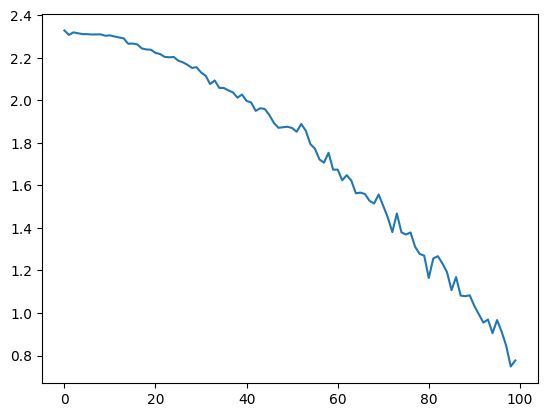

In [10]:
plt.plot(range(100), losses)

### BitLinear

Now let's try to implement the BitLinear layer. We'll just go line-by-line down the paper.

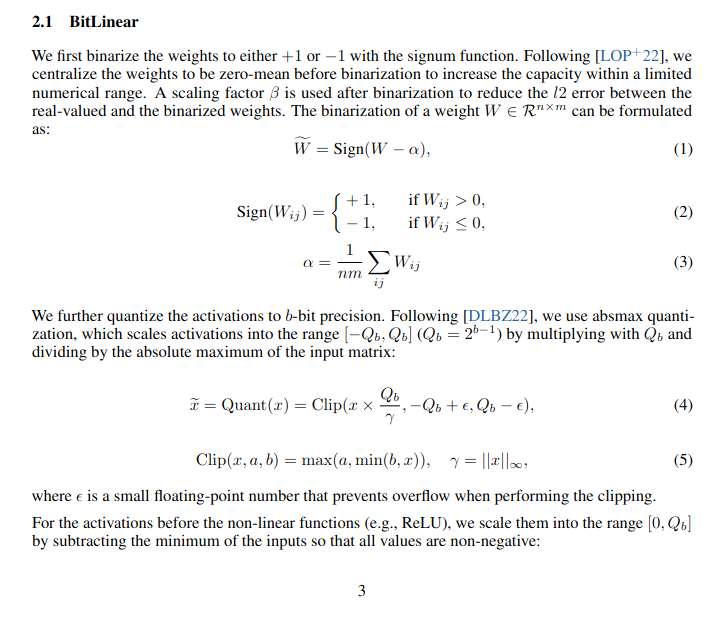

In [68]:
def activation_quant(x):
    scale = 127.0 / x.abs().max(dim=-1, keepdim=True).values.clamp_(min=1e-5)
    y = (x * scale).round().clamp_(-128, 127) / scale
    return y

In [69]:
def weight_quant(w):
    scale = 1.0 / w.abs().mean().clamp_(min=1e-5)
    u = (w * scale).round().clamp_(-1, 1) / scale
    return u

In [70]:
# https://github.com/deepsilicon/1.58bits/blob/3a8d2b3eed56ebe3c0f4592b29b25b28c2976911/llama-main/llama/bitlinear158.py#L25
def RMSNorm(x, eps=1e-6):
    return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + eps)

In [71]:
class BitLinear(nn.Linear):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        w = self.weight
        x_norm = RMSNorm(x)
        # A trick for implementing Straight-Through-Estimator (STE) using detach()
        x_quant = x_norm + (activation_quant(x_norm) - x_norm).detach()
        w_quant = w + (weight_quant(w) - w).detach()
        y = F.linear(x_quant, w_quant)
        return y

In [72]:
model = nn.Sequential(
    nn.Flatten(),
    BitLinear(784, 128, bias=False),  # TODO: Replace this with a BitLinear layer. Compare results.
    BitLinear(128, 10, bias=False),
    nn.LogSoftmax(dim=1),
)

In [76]:
w1 = list(model.parameters())[0]
w2 = list(model.parameters())[1]
w1.shape, w2.shape

(torch.Size([128, 784]), torch.Size([10, 128]))

In [79]:
weight_quant(w1)

tensor([[ 0.0179, -0.0179, -0.0179,  ..., -0.0179, -0.0179, -0.0179],
        [ 0.0000,  0.0179, -0.0179,  ...,  0.0000,  0.0179, -0.0179],
        [-0.0179, -0.0179,  0.0179,  ...,  0.0179,  0.0000, -0.0179],
        ...,
        [ 0.0179,  0.0179,  0.0179,  ...,  0.0179,  0.0000, -0.0179],
        [ 0.0179, -0.0179, -0.0000,  ..., -0.0179,  0.0179, -0.0179],
        [ 0.0179,  0.0000,  0.0179,  ...,  0.0000, -0.0179, -0.0179]],
       grad_fn=<DivBackward0>)

In [78]:
w_quant = w1 + (weight_quant(w1) - w1).detach()
w_quant

tensor([[ 0.0179, -0.0179, -0.0179,  ..., -0.0179, -0.0179, -0.0179],
        [ 0.0000,  0.0179, -0.0179,  ...,  0.0000,  0.0179, -0.0179],
        [-0.0179, -0.0179,  0.0179,  ...,  0.0179,  0.0000, -0.0179],
        ...,
        [ 0.0179,  0.0179,  0.0179,  ...,  0.0179,  0.0000, -0.0179],
        [ 0.0179, -0.0179,  0.0000,  ..., -0.0179,  0.0179, -0.0179],
        [ 0.0179,  0.0000,  0.0179,  ...,  0.0000, -0.0179, -0.0179]],
       grad_fn=<AddBackward0>)

In [73]:
it = iter(mnist_dl)
xs, ys = next(it)
ps = model(xs)
loss = -torch.gather(ps, 1, ys.unsqueeze(1)).mean()
loss.backward()

1.weight tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
2.weight tensor([[-7.7910e-02,  3.2442e-02,  3.0046e-03,  ..., -9.8792e-03,
          5.3388e-02, -6.5271e-03],
        [ 5.9008e-02, -1.3260e-01,  4.2386e-02,  ..., -5.0204e-02,
         -1.5867e-02, -1.3297e-02],
        [-2.9125e-02,  2.4978e-02,  6.3288e-02,  ...,  5.4509e-02,
          2.2328e-02, -9.7508e-03],
        ...,
        [-1.5554e-02, -4.6474e-02, -1.6535e-03,  ...,  2.3371e-02,
         -1.6177e-03,  8.1371e-03],
        [-1.2671e-04, -2.9736e-02, -8.2746e-03,  ...,  1.0856e-03,
         -5.1015e-03, -1.5891e-02],
        [ 3.5612e-02, -7.1430e-03, -5.9506e-02,  ..., -1.6672e-03,
         -1.2650e-02,  1.3228e-02]])


In [66]:
def train(model, dl, lr=0.001):
    it = iter(dl)
    losses = []
    for xs, ys in tqdm(it, total=1):
        ps = model(xs)
        loss = -torch.gather(ps, 1, ys.unsqueeze(1)).mean()
        losses.append(loss.detach())
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * lr
    return model, losses

In [67]:
model, losses = train(model, mnist_dl)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([[ 0.0179,  0.0000, -0.0179,  ...,  0.0000, -0.0179,  0.0179],
        [ 0.0000,  0.0179, -0.0179,  ...,  0.0000, -0.0179,  0.0000],
        [ 0.0000,  0.0179,  0.0000,  ...,  0.0179,  0.0000,  0.0179],
        ...,
        [-0.0179,  0.0179, -0.0179,  ..., -0.0179,  0.0179, -0.0179],
        [-0.0179,  0.0179,  0.0000,  ...,  0.0179,  0.0179, -0.0179],
        [ 0.0179,  0.0179, -0.0179,  ..., -0.0179, -0.0179,  0.0000]],
       grad_fn=<AddBackward0>)
tensor([[-1.1846, -1.3011,  0.7574,  ..., -0.5826, -0.9127, -0.4661],
        [-1.0134, -0.5067,  0.5600,  ..., -0.4534, -2.0001, -1.2801],
        [ 0.0228,  0.2960, -0.4781,  ..., -1.4343, -0.0455,  0.6147],
        ...,
        [-2.0671,  0.2756,  0.4725,  ..., -1.6733,  0.6890

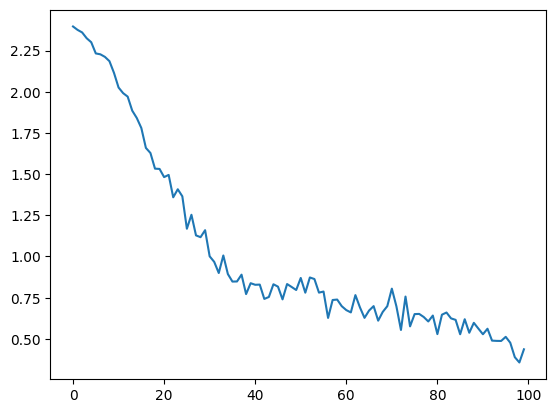

In [60]:
plt.plot(range(100), losses)

In [61]:
# 2.1.1 - 2.1.3
# Re-ordered from the paper so they'll execute.
torch.manual_seed(42)
W = torch.randn((2, 4))  # Random weights.

# (2)
def Sign(Wij):
    return torch.where(Wij > 0, 1, -1)

# (3)
α = weights.mean()  # α is unicode 03b1

# (1)
Ŵ = Sign(W - α)  # Ŵ is unicode 0174

NameError: name 'weights' is not defined

In [ ]:
W, Ŵ

In [ ]:
# 2.1.4 - 2.1.6
x = torch.tensor([[-2, 2], [3, 4]])  # Arbitrary input
ε = 1e-5                             # 03b5
b = 8                                # 8-bit quantization
Qb = 2**(b-1)

# (4)
def Quant_1(x):
    """
    From the paper:

        We further quantize the activations to b-bit precision. Following [DLBZ22 ], we use absmax quanti-
        zation, which scales activations into the range [−Qb, Qb] (Qb = 2b−1) by multiplying with Qb and
        dividing by the absolute maximum of the input matrix
    """
    return Clip(x * (Qb / γ(x)), -Qb + ε, Qb - ε)

# (5)
def γ(x):  # 03b3
    return x.abs().max()

# (5)
def Clip(xs, a, b):  # a=min, b=max
    return torch.clamp(xs, a, b)

# (6)
def Quant_2(x):
    """
    From the paper:
    
        For the activations before the non-linear functions (e.g., ReLU), we scale them into the range [0, Qb]
        by subtracting the minimum of the inputs so that all values are non-negative
    """
    return Clip((x - x.min()) * (Qb / γ(x)), -Qb + ε, Qb - ε)

In [160]:

def quant(x, b, γ):
    return clip(xs * (Qb(b) / γ), -Qb(b) + ε, Qb(b) - ε)


In [162]:

quant(sample_x, 8, γ(sample_x))

tensor([[-128.0000,  102.4000],
        [  12.8000,   25.6000],
        [  38.4000,   51.2000]])

In [ ]:
class BitLinear(nn.Module):
    def __init__(self):
        pass
    def forward(self, xs):
        pass

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    nn.Linear(128, 10),
    nn.LogSoftmax(dim=1),
)